## Read in peripheral study recording

In [1]:
# given a filename, generate a pandas dataframe with all recording stuff

# L, R, combined fields

In [2]:
import sys
sys.executable

'c:\\users\\abhijat\\appdata\\local\\programs\\python\\python38\\python.exe'

In [3]:
from ibmm import EyeClassifier
# from ibmm_online import EyeClassifierOnline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import cm

from parser_utils import read_periph_recording
from pathlib import Path
from tqdm import tqdm
import pickle as pkl

In [4]:
%matplotlib ipympl

In [5]:
%load_ext autoreload
%autoreload 2

## Load data (txt or pkl)

In [6]:
path_to_recording = "C:\\EGLC\\\carla\\PythonAPI\\examples\\recordings\\sud32.txt"
path_to_recording = "data/george-55.txt"
path_to_recording = "data/samuel_kim-55.txt"

recording_name = Path(path_to_recording).stem
recdf_pklname = Path("temp_data").joinpath(recording_name+".pkl")

try:
    df1 = pd.read_pickle(recdf_pklname)
except FileNotFoundError:
    df1 = read_periph_recording(path_to_recording)
    df1.to_pickle(recdf_pklname)
df1 = df1.convert_dtypes()

## Data Playground and Sanity checks

In [7]:
gazeRaySplitDF = pd.DataFrame(df1["GazeRay"].to_list(), columns=['gaze_x', 'gaze_y', 'gaze_z'], index=df1.index)
# print(gazeRaySplitDF)
df2 = df1.join(gazeRaySplitDF)
gaze_pitches = np.arctan2(df2.gaze_z, df2.gaze_x)*180/np.pi
gaze_yaws = np.arctan2(df2.gaze_y, df2.gaze_x)*180/np.pi

low_conf_gazeidcs = (gaze_pitches*gaze_yaws == 0)
gaze_pitches = gaze_pitches[~low_conf_gazeidcs]
gaze_yaws = gaze_yaws[~low_conf_gazeidcs]


print(np.min(gaze_pitches),np.max(gaze_pitches))
print(np.min(gaze_yaws),np.max(gaze_yaws))

-39.78352586104586 11.97510195428324
-38.972538095638754 38.93288751364551


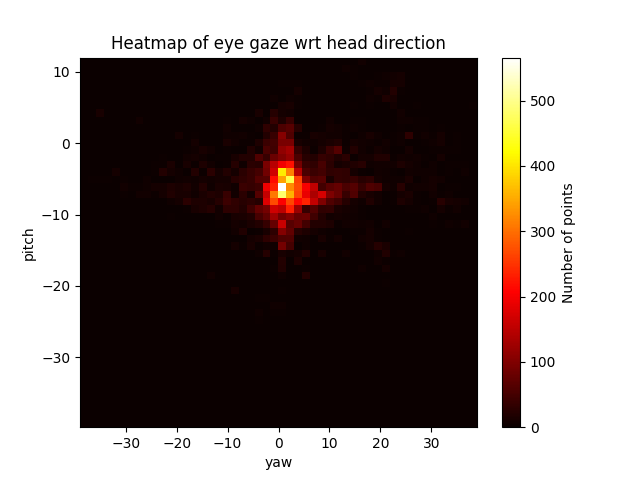

In [8]:
#gaze_pitches = gaze_pitches[1000:7000]
#gaze_yaws = gaze_yaws[6000:7000]

# Generate heat map of eye gaze wrt head pos
plt.figure()
plt.hist2d(gaze_yaws, gaze_pitches,
           bins=50, cmap='hot')
cb = plt.colorbar()
cb.set_label('Number of points')
plt.title('Heatmap of eye gaze wrt head direction')
# plt.xlim(-20,20)
# plt.ylim(-20,20)
plt.xlabel('yaw')
plt.ylabel('pitch')
plt.show()

In [9]:
# find the indices where lights came on and went off
lighton_rows = df1["LightOn"].diff().fillna(0)==1
lightoff_rows = df1["LightOn"].diff().fillna(0)==-1
df1[lighton_rows].head()
lighton_idcs = df1[lighton_rows].index
# df1[lightoff_idcs].head()
num_targets_spawned = sum(lighton_rows)

In [10]:
# find the indices where the button was pressed
buttonPress_rows = df1["ButtonPressed"].diff().fillna(0)==1
buttonRelease_rows = df1["ButtonPressed"].diff().fillna(0)==-1
# df1[buttonPress_idcs]

In [11]:
# average target appearance time
df1[buttonRelease_rows].TimeElapsed.reset_index()  - df1[buttonPress_rows].TimeElapsed.reset_index()

,FrameNum,TimeElapsed
0,-331.0,-7.792106
1,-453.0,-10.07325
2,-655.0,-14.5436
3,-804.0,-17.8615
4,-380.0,-8.4383
5,-982.0,-21.8131
6,-589.0,-13.0872
7,-559.0,-12.4136
8,-99.0,-2.209
9,-406.0,-9.022


In [12]:
num_button_presses = sum(buttonPress_rows)
print("{} targets spawned".format(num_targets_spawned))
print("{} responses recorded".format(num_button_presses)) # may or may not be all accurate responses that correspond to targets?

45 targets spawned
32 responses recorded


In [13]:
colBP = df1["ButtonPressed"].astype(int)

In [14]:
df1.columns

Index(['gaze2target_pitch', 'gaze2target_yaw', 'head2target_pitch',
       'head2target_yaw', 'LightOn', 'ButtonPressed', 'WorldPos', 'WorldRot',
       'AbsoluteEyeOrigin', 'T_SRanipal', 'T_Carla', 'FrameSeq', 'GazeRay',
       'RelativeEyeOrigin', 'Vergence', 'HMDLoc', 'HMDRot', 'EgoVel',
       'LGazeRay', 'LEyeOrigin', 'RGazeRay', 'REyeOrigin', 'LEyeOpenness',
       'REyeOpenness', 'LPupilPos', 'RPupilPos', 'LPupilDiam', 'RPupilDiam',
       'FActorName', 'FActorPoint', 'FActorDist', 'GazeV', 'LGazeV', 'RGazeV',
       'LEyeOpenV', 'REyeOpenV', 'LPupilPosV', 'RPupilPosV', 'Throttle',
       'Steering', 'Brake', 'ToggleRev', 'TurnSignalLeft', 'TurnSignalRight',
       'Handbrake', 'TimeElapsed'],
      dtype='object')

## Hits and Misses calculation

In [15]:
# for every light appearance
# find the nearest button press, before the next target appearance
max_reaction_time_allowed = 5 #seconds
time_offsets = []
hits_and_misses = []
for idx_num, lighton_idx in tqdm(enumerate(lighton_idcs)):
    # while not found_buttonpress or lighton_idcs[idx_num+1]:
    offset = 0
    target_tuple = (df1.loc[lighton_idx], False)
    while lighton_idx+offset < max(df1.index):
        time_offset = df1.loc[lighton_idx+offset, "TimeElapsed"] - df1.loc[lighton_idx, "TimeElapsed"]   
        if (df1.loc[lighton_idx+offset, "ButtonPressed"] == 1):
            # print("{0:1.2f}s".format(time_offset))
            time_offsets += [time_offset]
            target_tuple = (df1.loc[lighton_idx], df1.loc[lighton_idx+offset])
            break
        else:
            if time_offset > max_reaction_time_allowed:
                break
            offset += 1
    hits_and_misses += [target_tuple]
print("{}/{} hits with a {}s average reaction time".format(len(time_offsets), len(lighton_idcs), sum(time_offsets)/len(time_offsets)))

45it [00:05,  8.19it/s]

32/45 hits with a 0.7779403125000003s average reaction time


(0.0, 2.0)

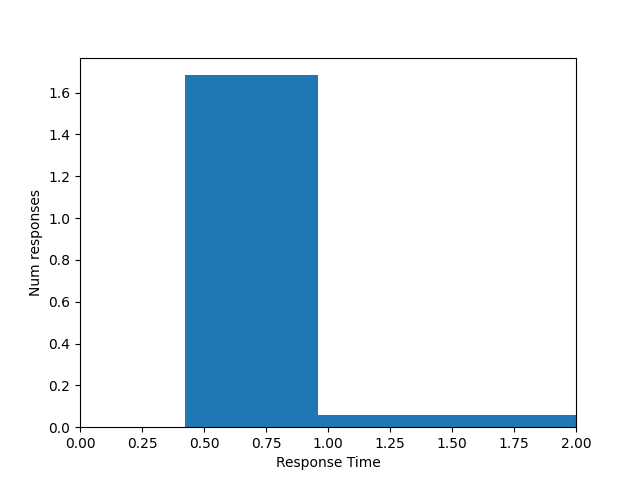

In [16]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(time_offsets, bins=8, density=True)
ax.set_xlabel('Response Time')
ax.set_ylabel('Num responses')
ax.set_xlim(0, 2)
# ax.set_title(r'sigma=15$')

In [17]:
# TODO find buttonpress false positives -- might have to iterate over button presses

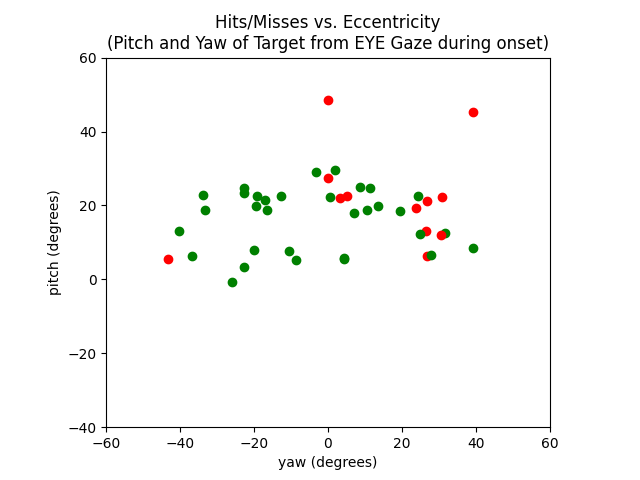

In [18]:
# Preliminary analysis
fig, ax = plt.subplots()

# plots of hits misses vs ecc
for target_tuple in hits_and_misses:
    target_response = True
    if target_tuple[1] is False:
        # miss
        target_response = False
        pass
    else:
        # hits
        pass
        # print(target_tuple[1].ButtonPressed)
    ax.scatter(target_tuple[0].gaze2target_yaw*180/np.pi,
               target_tuple[0].gaze2target_pitch*180/np.pi,
               c='g' if target_response else 'r')
    ax.set_title("Hits/Misses vs. Eccentricity\n(Pitch and Yaw of Target from EYE Gaze during onset)")
    
    # ax.scatter(target_tuple[0].head2target_yaw*180/np.pi, target_tuple[0].head2target_pitch*180/np.pi, c='g' if target_response else 'r')
    # ax.set_title("Hits/Misses vs. Eccentricity\n(Pitch and Yaw of Target from HEAD Gaze during onset)")
    
    ax.set_xlabel("yaw (degrees)")
    ax.set_ylabel("pitch (degrees)")
    ax.set_xlim(-60, 60)
    ax.set_ylim(-40, 60)
    ax.set_aspect('equal')
    # ax.show()
    

In [19]:
# write the target tuples to disk?
# target_tuple_filename = Path("temp_data").joinpath(recording_name+"_targets_responses.pkl")
# pkl.dumps(hits_and_misses, target_tuple_filename)

## Gaze event detection (eye gaze vector only)

In [20]:
from ibmm import EyeClassifier
from ibmm_online import EyeClassifierOnline

In [21]:
LgazeRaySplitDF = pd.DataFrame(np.array(df1["LGazeRay"].to_list()), columns=['x', 'y', 'z'], index=df1.index).convert_dtypes()
LgazeRaySplitDF['timestamp'] = df1["TimeElapsed"]
LgazeRaySplitDF['confidence'] = df1["LEyeOpenV"].astype(int) # remove all gazes where an eye was closed

RgazeRaySplitDF = pd.DataFrame(np.array(df1["RGazeRay"].to_list()), columns=['x', 'y', 'z'], index=df1.index).convert_dtypes()
RgazeRaySplitDF['timestamp'] = df1["TimeElapsed"]
RgazeRaySplitDF['confidence'] = df1["REyeOpenV"].astype(int) # remove all gazes where an eye was closed

pdGaze = pd.DataFrame(gazeRaySplitDF, columns = ['x','y','z']) #.convert_dtypes()
pdGaze['timestamp'] = df1["TimeElapsed"]
pdGaze['confidence'] = (df1["LEyeOpenV"]*df1["REyeOpenV"]).astype(int)

velL = EyeClassifier.preprocess(LgazeRaySplitDF, dist_method='vector')
velL.velocity = velL.velocity.astype(float)
velR = EyeClassifier.preprocess(RgazeRaySplitDF, dist_method='vector')
velR.velocity = velR.velocity.astype(float)

In [22]:
model = EyeClassifier()
model.fit(eyes=(velL, velR))

In [23]:
labels, indiv_labels = model.predict(eyes=(velL, velR))
# print(labels)
# 0- fix, 1- sac, -1 -> noise
labels_unique = labels[1::2]
labels_unique.index = np.arange(1, len(labels_unique) + 1) # start index from 1 instead of 0
labels_np = labels_unique.to_numpy()
print("labels_np.shape: ", labels_np.shape)
# add the labels to the original df:
recdf_with_labels = df2.join(labels_unique["label"])

labels_np.shape:  (20751, 5)


In [24]:
print("Num fixation total pts: ", np.sum(labels_np[:,2]))
print("Num saccades total pts: ", np.sum(labels_np[:,3]))
print("Num noise total pts: ", np.sum(labels_np[:,4]))
print()
# filter the consecutives
print("Num fixations: ", np.sum(np.diff(labels_np[:, 2]) == 1))
print("Num saccades: ", np.sum(np.diff(labels_np[:, 3]) == 1))
print("Num noise: ", np.sum(np.diff(labels_np[:, 4]) == 1))
print("Num LightOns: ", num_targets_spawned)

Num fixation total pts:  19066
Num saccades total pts:  1359
Num noise total pts:  326

Num fixations:  965
Num saccades:  953
Num noise:  107
Num LightOns:  45


## OFD analysis

45/45 valid targets
42 fixation onsets, 3 sacc, 0 noise


Text(0.5, 1.0, 'Hits/Misses on Gaze Eccentricity vs. OFD')

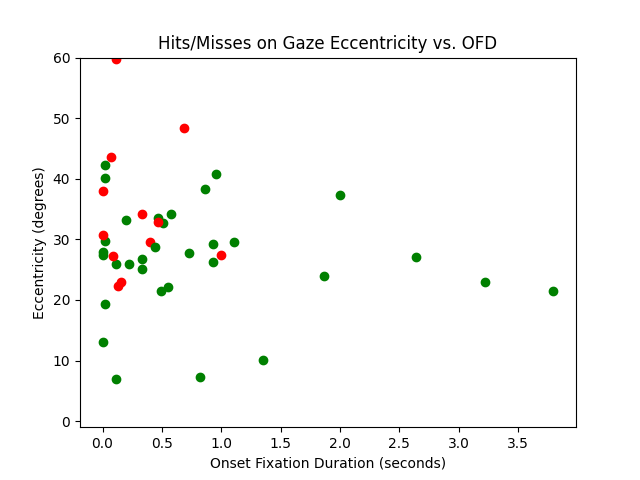

In [25]:
# target tuples, go back and find labels
saccade_onsets = 0
fixation_onsets = 0
noise_onsets = 0

fig, ax = plt.subplots()
graph_tuples = []

for target_tuple in hits_and_misses:
    # for either hit or miss, go back and find the ofd
    # check if you're in a fixation rn
    if target_tuple[0].GazeV==0: # check gaze validity 
        continue
    target_locindf = target_tuple[0].name
    onset_gaze_event = recdf_with_labels.loc[target_locindf].label
    
    OFD = 0
    
    if onset_gaze_event == 0:
        fixation_onsets += 1
        # go back and look at when this current fixation ends
        # labels going back from current gaze
        labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
        np.diff(labels_upto_curr)
        labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
        label_diff = np.diff(labels_upto_curr)!=0
        first_fixation_idx = target_locindf - np.argmax(label_diff)
        OFD = recdf_with_labels.loc[target_locindf].TimeElapsed -\
                recdf_with_labels.loc[first_fixation_idx].TimeElapsed
        
        eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
                                      recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
        ax.scatter(OFD, eccentricity, c='r' if target_tuple[1] is False else 'g')
        graph_tuples += (OFD, eccentricity, target_tuple[1] is False)
    elif onset_gaze_event == 1:
        saccade_onsets += 1
        OFD = 0        
        eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
                                      recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
        ax.scatter(OFD, eccentricity, c='r' if target_tuple[1] is False else 'g')
        graph_tuples += (OFD, eccentricity, target_tuple[1] is False)
    else:
        noise_onsets += 1
    # print(target_locindf, OFD)
print("{}/{} valid targets".format(
        fixation_onsets+saccade_onsets+noise_onsets,
        len(hits_and_misses)))
print("{} fixation onsets, {} sacc, {} noise".format(fixation_onsets, saccade_onsets, noise_onsets))

#plt.xlim(0, )
ax.set_ylim(-1, 60)
ax.set_xlabel("Onset Fixation Duration (seconds)")
ax.set_ylabel("Eccentricity (degrees)")
ax.set_title("Hits/Misses on Gaze Eccentricity vs. OFD")

## Graph data write

In [26]:
# temp hack for henny meeting: save graph tuples
graph_data_filname = Path("temp_data").joinpath(recording_name+"_OFDvEcc.pkl")
with open(graph_data_filname, 'wb') as f:
    pkl.dump(graph_tuples, f)

In [27]:
# # dump all this data somewhere
# targetevents_df = pd.DataFrame(columns=recdf_with_labels.columns)
# # target tuples, go back and find labels
# saccade_onsets = 0
# fixation_onsets = 0
# noise_onsets = 0

# fig, ax = plt.subplots()


# for target_tuple in hits_and_misses:
#     # for either hit or miss, go back and find the ofd
#     # check if you're in a fixation rn
#     if target_tuple[0].GazeV==0: # check gaze validity 
#         continue
#     target_locindf = target_tuple[0].name
#     onset_gaze_event = recdf_with_labels.loc[target_locindf].label
    
#     OFD = 0
    
#     if onset_gaze_event == 0:
#         fixation_onsets += 1
#         # go back and look at when this current fixation ends
#         # labels going back from current gaze
#         labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
#         np.diff(labels_upto_curr)
#         labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
#         label_diff = np.diff(labels_upto_curr)!=0
#         first_fixation_idx = target_locindf - np.argmax(label_diff)
#         OFD = recdf_with_labels.loc[target_locindf].TimeElapsed -\
#                 recdf_with_labels.loc[first_fixation_idx].TimeElapsed
        
#         eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
#                                       recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
#         ax.scatter(OFD, eccentricity, c='r' if target_tuple[1] is False else 'g')
        
#     elif onset_gaze_event == 1:
#         saccade_onsets += 1
#         OFD = 0        
#         eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
#                                       recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
#         ax.scatter(OFD, eccentricity, c='r' if target_tuple[1] is False else 'g')
        
#     else:
#         noise_onsets += 1
#     # print(target_locindf, OFD)
# print("{}/{} valid targets".format(
#         fixation_onsets+saccade_onsets+noise_onsets,
#         len(hits_and_misses)))
# print("{} fixation onsets, {} sacc, {} noise".format(fixation_onsets, saccade_onsets, noise_onsets))

# #plt.xlim(0, )
# ax.set_ylim(-1, 60)
# ax.set_xlabel("Onset Fixation Duration (seconds)")
# ax.set_ylabel("Eccentricity (degrees)")
# ax.set_title("Hits/Misses on Gaze Eccentricity vs. OFD")

## Gaze event detection (eye gaze + head gaze angles)

In [28]:
from ibmm import EyeClassifier
from ibmm_online import EyeClassifierOnline

In [29]:
# yaw = df1.gaze2target_yaw + df1.head2target_yaw
# pitch = df1.gaze2target_pitch + df1.head2target_pitch


ypGaze = pd.DataFrame(columns = ['x','y']) #.convert_dtypes()
## TODO these need to change because this is inaccurate
pdGaze.x = df1.gaze2target_yaw + df1.head2target_yaw 
pdGaze.y = df1.gaze2target_pitch + df1.head2target_pitch
##
pdGaze['timestamp'] = df1["TimeElapsed"]
pdGaze['confidence'] = (df1["GazeV"]).astype(bool)

velL = EyeClassifier.preprocess(LgazeRaySplitDF, dist_method='vector')
velL.velocity = velL.velocity.astype(float)
velR = EyeClassifier.preprocess(RgazeRaySplitDF, dist_method='vector')
velR.velocity = velR.velocity.astype(float)

In [30]:
model = EyeClassifier()
model.fit(eyes=(velL, velR))